2024-05-31: final check; this version is used for the arxiv 1.0 version of paper

In [1]:
import pandas as pd
from IPython.display import display
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

sns.set_theme()


clemrun_base = '/Users/das/work/svn/Gits/a_Projects/101_clembench/clembench-runs'

v1 = pd.read_csv(clemrun_base + '/v1.0/results.csv')
v1 = v1.rename(columns={v1.columns[0]: 'models'})
v1 = v1.set_index('models')

colname_score = v1.columns[0]
colname_played = v1.columns[1]
colname_quality = v1.columns[2]

v2 = pd.read_csv(clemrun_base + '/v1.6/results.csv')
v2 = v2.rename(columns={v2.columns[0]: 'models'})
v2 = v2.set_index('models')

both = set(v1.index).intersection(set(v2.index))

In [2]:
v2.index = v2.index.str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()

/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_92468/1669827204.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  v2.index = v2.index.str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()


In [3]:
v1.index = v1.index.str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()

/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_92468/622844938.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  v1.index = v1.index.str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()


In [4]:
v0 = pd.read_csv(clemrun_base + '/v0.9/results.csv')
v0 = v0.rename(columns={v0.columns[0]: 'models'})
v0 = v0.set_index('models')

In [5]:
v0.index

Index(['claude-v1.3-t0.0--claude-v1.3-t0.0',
       'falcon-40b-t0.0--falcon-40b-t0.0',
       'gpt-3.5-turbo-t0.0--gpt-3.5-turbo-t0.0',
       'gpt-3.5-turbo-t0.0--gpt-4-t0.0', 'gpt-4-t0.0--gpt-3.5-turbo-t0.0',
       'gpt-4-t0.0--gpt-4-t0.0', 'koala-13b-t0.0--koala-13b-t0.0',
       'luminous-supreme-t0.0--luminous-supreme-t0.0',
       'oasst-12b-t0.0--oasst-12b-t0.0',
       'text-davinci-003-t0.0--text-davinci-003-t0.0',
       'vicuna-13b-t0.0--vicuna-13b-t0.0'],
      dtype='object', name='models')

In [6]:
v0 = v0.drop(axis=0, labels=['gpt-3.5-turbo-t0.0--gpt-4-t0.0', 'gpt-4-t0.0--gpt-3.5-turbo-t0.0'])

In [7]:
v0.index = v0.index.str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()

/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_92468/3474250429.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  v0.index = v0.index.str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()


In [8]:
v0.index

Index(['claude-v1.3', 'falcon-40b', 'gpt-3.5-turbo', 'gpt-4', 'koala-13b',
       'luminous-supreme', 'oasst-12b', 'text-davinci-003', 'vicuna-13b'],
      dtype='object', name='models')

### Tracking the evolution of the benchmark, and of the models tested with it

In [9]:
v0.shape, v1.shape, v2.shape

((9, 24), (41, 24), (55, 24))

##### v2 = v1.6

In [10]:
v2.loc[:,colname_score].sort_values(ascending=False)

models
gpt-4-turbo-2024-04-09            58.30
gpt-4-0125-preview                52.50
gpt-4-1106-preview                51.99
gpt-4-0613                        51.09
gpt-4o-2024-05-13                 48.34
claude-3-opus-20240229            42.42
gemini-1.5-pro-latest             41.72
meta-llama-3-70b-instruct-hf      35.11
llama-3-70b-instruct-anyscale     33.36
claude-2.1                        32.50
gemini-1.5-flash-latest           32.00
claude-3-sonnet-20240229          30.53
qwen1.5-72b-chat                  30.37
mistral-large-2402                28.17
gpt-3.5-turbo-0125                27.22
gemini-1.0-pro                    26.95
command-r-plus                    24.94
openchat_3.5                      23.64
claude-3-haiku-20240307           22.49
sheep-duck-llama-2-70b-v1.1       21.50
meta-llama-3-8b-instruct-hf       19.99
llama-3-8b-instruct-anyscale      19.32
openchat-3.5-1210                 18.22
wizardlm-70b-v1.0                 17.40
openchat-3.5-0106                

Arrgh We now have double entries for llama-3, one with inference via anyscale, one with local inference via transformers....
Need to drop the anyscale ones, and change the model names for the hf llama3s.

In [11]:
v2 = v2[~v2.index.str.contains('anyscale')].copy(deep=True)
len(v2)

53

In [12]:
v2.index = v2.index.str.replace(r'meta-(\w*)', r'\1')
v2.index = v2.index.str.replace(r'(\w*)-hf', r'\1')

/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_92468/3568535097.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  v2.index = v2.index.str.replace(r'meta-(\w*)', r'\1')
/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_92468/3568535097.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  v2.index = v2.index.str.replace(r'(\w*)-hf', r'\1')


In [13]:
v2.index

Index(['codellama-34b-instruct', 'llama-3-70b-instruct', 'llama-3-8b-instruct',
       'mistral-7b-instruct-v0.1', 'mistral-7b-instruct-v0.2',
       'mixtral-8x22b-instruct-v0.1', 'mixtral-8x7b-instruct-v0.1',
       'nous-hermes-2-mixtral-8x7b-sft', 'qwen1.5-0.5b-chat',
       'qwen1.5-1.8b-chat', 'qwen1.5-14b-chat', 'qwen1.5-32b-chat',
       'qwen1.5-72b-chat', 'qwen1.5-7b-chat', 'sus-chat-34b',
       'starling-lm-7b-beta', 'wizardlm-13b-v1.2', 'wizardlm-70b-v1.0',
       'yi-1.5-34b-chat', 'yi-1.5-6b-chat', 'yi-1.5-9b-chat', 'yi-34b-chat',
       'claude-2.1', 'claude-3-haiku-20240307', 'claude-3-opus-20240229',
       'claude-3-sonnet-20240229', 'codegemma-7b-it', 'command-r-plus',
       'command-r', 'dolphin-2.5-mixtral-8x7b', 'gemini-1.0-pro',
       'gemini-1.5-flash-latest', 'gemini-1.5-pro-latest', 'gemma-1.1-2b-it',
       'gemma-1.1-7b-it', 'gemma-7b-it', 'gpt-3.5-turbo-0125',
       'gpt-4-0125-preview', 'gpt-4-0613', 'gpt-4-1106-preview',
       'gpt-4-turbo-2024-04-09

In [14]:
v2.index.tolist()

['codellama-34b-instruct',
 'llama-3-70b-instruct',
 'llama-3-8b-instruct',
 'mistral-7b-instruct-v0.1',
 'mistral-7b-instruct-v0.2',
 'mixtral-8x22b-instruct-v0.1',
 'mixtral-8x7b-instruct-v0.1',
 'nous-hermes-2-mixtral-8x7b-sft',
 'qwen1.5-0.5b-chat',
 'qwen1.5-1.8b-chat',
 'qwen1.5-14b-chat',
 'qwen1.5-32b-chat',
 'qwen1.5-72b-chat',
 'qwen1.5-7b-chat',
 'sus-chat-34b',
 'starling-lm-7b-beta',
 'wizardlm-13b-v1.2',
 'wizardlm-70b-v1.0',
 'yi-1.5-34b-chat',
 'yi-1.5-6b-chat',
 'yi-1.5-9b-chat',
 'yi-34b-chat',
 'claude-2.1',
 'claude-3-haiku-20240307',
 'claude-3-opus-20240229',
 'claude-3-sonnet-20240229',
 'codegemma-7b-it',
 'command-r-plus',
 'command-r',
 'dolphin-2.5-mixtral-8x7b',
 'gemini-1.0-pro',
 'gemini-1.5-flash-latest',
 'gemini-1.5-pro-latest',
 'gemma-1.1-2b-it',
 'gemma-1.1-7b-it',
 'gemma-7b-it',
 'gpt-3.5-turbo-0125',
 'gpt-4-0125-preview',
 'gpt-4-0613',
 'gpt-4-1106-preview',
 'gpt-4-turbo-2024-04-09',
 'gpt-4o-2024-05-13',
 'llama-2-70b-chat',
 'mistral-large-24

In [15]:
v2_open = \
['codellama-34b-instruct',
 'llama-3-70b-instruct',
 'llama-3-8b-instruct',
 'mistral-7b-instruct-v0.1',
 'mistral-7b-instruct-v0.2',
 'mixtral-8x22b-instruct-v0.1',
 'mixtral-8x7b-instruct-v0.1',
 'nous-hermes-2-mixtral-8x7b-sft',
 'qwen1.5-0.5b-chat',
 'qwen1.5-1.8b-chat',
 'qwen1.5-14b-chat',
 'qwen1.5-32b-chat',
 'qwen1.5-72b-chat',
 'qwen1.5-7b-chat',
 'sus-chat-34b',
 'starling-lm-7b-beta',
 'wizardlm-13b-v1.2',
 'wizardlm-70b-v1.0',
 'yi-1.5-34b-chat',
 'yi-1.5-6b-chat',
 'yi-1.5-9b-chat',
 'yi-34b-chat',
 'codegemma-7b-it',
 'command-r-plus',
 'command-r',
 'dolphin-2.5-mixtral-8x7b',
 'gemma-1.1-2b-it',
 'gemma-1.1-7b-it',
 'gemma-7b-it',
 'llama-2-70b-chat',
 'openchat-3.5-0106',
 'openchat-3.5-1210',
 'openchat_3.5',
 'sheep-duck-llama-2-13b',
 'sheep-duck-llama-2-70b-v1.1',
 'tulu-2-dpo-70b',
 'vicuna-13b-v1.5',
 'vicuna-33b-v1.3'
]

In [16]:
v2_closed = set(v2.index.tolist()) - set(v2_open)

In [17]:
v2_closed

{'claude-2.1',
 'claude-3-haiku-20240307',
 'claude-3-opus-20240229',
 'claude-3-sonnet-20240229',
 'gemini-1.0-pro',
 'gemini-1.5-flash-latest',
 'gemini-1.5-pro-latest',
 'gpt-3.5-turbo-0125',
 'gpt-4-0125-preview',
 'gpt-4-0613',
 'gpt-4-1106-preview',
 'gpt-4-turbo-2024-04-09',
 'gpt-4o-2024-05-13',
 'mistral-large-2402',
 'mistral-medium-2312'}

In [18]:
# v2.loc[:, 'ow/gt'] = '🔓'
# v2.loc[v2.index.isin(v2_closed), 'ow/gt'] = '🔑'

## Maybe for screenshots for social media...
#v2.loc[:, 'ow/gt'] = '🏋🏽‍♀️'
#v2.loc[v2.index.isin(v2_closed), 'ow/gt'] = '🔒'#

v2.loc[:, 'ow/gt'] = 'ow'
v2.loc[v2.index.isin(v2_closed), 'ow/gt'] = '$$'


In [19]:
v2

,"-, clemscore","all, Average % Played","all, Average Quality Score","imagegame, % Played","imagegame, Quality Score","imagegame, Quality Score (std)","privateshared, % Played","privateshared, Quality Score","privateshared, Quality Score (std)","referencegame, % Played","referencegame, Quality Score","referencegame, Quality Score (std)","taboo, % Played","taboo, Quality Score","taboo, Quality Score (std)","wordle, % Played","wordle, Quality Score","wordle, Quality Score (std)","wordle_withclue, % Played","wordle_withclue, Quality Score","wordle_withclue, Quality Score (std)","wordle_withcritic, % Played","wordle_withcritic, Quality Score","wordle_withcritic, Quality Score (std)",ow/gt
models,,,,,,,,,,,,,,,,,,,,,,,,,
codellama-34b-instruct,14.35,33.57,42.76,0.0,NaN,NaN,0.0,NaN,NaN,100.00,94.44,22.97,51.67,51.61,50.80,56.67,0.00,0.00,26.67,25.00,46.29,0.00,NaN,NaN,ow
llama-3-70b-instruct,35.11,80.72,43.50,0.0,NaN,NaN,100.0,84.37,13.69,100.00,64.44,48.00,91.67,70.30,39.37,90.00,1.85,6.81,96.67,14.37,32.34,86.67,25.64,39.08,ow
llama-3-8b-instruct,19.99,76.10,26.27,0.0,NaN,NaN,96.0,58.91,30.05,100.00,46.11,49.99,100.00,37.78,45.08,86.67,0.00,0.00,83.33,14.00,33.91,66.67,0.83,3.73,ow
mistral-7b-instruct-v0.1,8.01,37.14,21.58,0.0,NaN,NaN,20.0,1.21,2.58,100.00,55.00,49.89,100.00,31.67,45.07,0.00,NaN,NaN,23.33,0.00,0.00,16.67,20.00,44.72,ow
mistral-7b-instruct-v0.2,9.75,36.91,26.42,0.0,NaN,NaN,0.0,NaN,NaN,100.00,38.33,48.76,65.00,0.00,0.00,50.00,0.00,0.00,26.67,43.75,49.55,16.67,50.00,50.00,ow
mixtral-8x22b-instruct-v0.1,12.69,52.14,24.33,0.0,NaN,NaN,0.0,NaN,NaN,100.00,36.67,48.32,58.33,40.00,49.71,96.67,0.00,0.00,60.00,15.00,33.30,50.00,30.00,41.40,ow
mixtral-8x7b-instruct-v0.1,8.17,47.62,17.15,0.0,NaN,NaN,0.0,NaN,NaN,61.67,41.44,49.49,51.67,9.68,30.05,96.67,0.00,0.00,76.67,19.13,35.28,46.67,15.48,36.08,ow
nous-hermes-2-mixtral-8x7b-sft,11.95,39.68,30.12,0.0,NaN,NaN,0.0,NaN,NaN,97.78,36.93,48.40,93.33,47.92,47.36,0.00,NaN,NaN,53.33,15.62,30.10,33.33,20.00,42.16,ow
qwen1.5-0.5b-chat,0.12,25.72,0.48,0.0,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,86.67,1.92,13.87,46.67,0.00,0.00,40.00,0.00,0.00,6.67,0.00,0.00,ow


In [20]:
v2.sort_values(by=colname_score, ascending=False)[[colname_score, 'ow/gt']]

,"-, clemscore",ow/gt
models,,
gpt-4-turbo-2024-04-09,58.30,$$
gpt-4-0125-preview,52.50,$$
gpt-4-1106-preview,51.99,$$
gpt-4-0613,51.09,$$
gpt-4o-2024-05-13,48.34,$$
claude-3-opus-20240229,42.42,$$
gemini-1.5-pro-latest,41.72,$$
llama-3-70b-instruct,35.11,ow
claude-2.1,32.50,$$


Distance best open (llama-3-70b-instruct) to best closed (gpt-4-turbo-2024-04-09)

In [21]:
58.30 - 33.36

24.939999999999998

In [22]:
### capped at 16, to save space
v2.loc[v2[colname_score] > 16].sort_values(by=colname_score, 
               ascending=False)[[colname_score, 'ow/gt']].to_latex(
    'Output/v1.6-score-table.tex',
    header=['sc', 'o/g'],
    float_format="%.2f")

/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_92468/3079169957.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  v2.loc[v2[colname_score] > 16].sort_values(by=colname_score,


Note: The LaTeX needs to be edited manually, as I can't seem to get it to stop putting the index label on its own header row.

Needs to look like this:
```
\begin{tabular}[t]{lrl}
\toprule
models &    sc & o/g \\
\midrule
```

##### v1 = v1.0

In [23]:
v1.index.tolist()

['codellama-34b-instruct-hf',
 'mistral-7b-instruct-v0.1',
 'mixtral-8x7b-instruct-v0.1',
 'nous-hermes-2-mixtral-8x7b-dpo',
 'sus-chat-34b',
 'wizard-vicuna-13b-uncensored-hf',
 'wizardlm-13b-v1.2',
 'wizardlm-70b-v1.0',
 'yi-34b-chat',
 'claude-2',
 'claude-2.1',
 'claude-instant-1.2',
 'claude-v1.3',
 'command',
 'deepseek-llm-67b-chat',
 'deepseek-llm-7b-chat',
 'falcon-7b-instruct',
 'gpt-3.5-turbo-0613',
 'gpt-3.5-turbo-1106',
 'gpt-4-0314',
 'gpt-4-0613',
 'gpt-4-1106-preview',
 'gpt4all-13b-snoozy',
 'koala-13b-hf',
 'llama-2-13b-chat-hf',
 'llama-2-70b-chat-hf',
 'llama-2-7b-chat-hf',
 'mistral-medium',
 'oasst-sft-4-pythia-12b-epoch-3.5',
 'openchat-3.5-0106',
 'openchat-3.5-1210',
 'openchat_3.5',
 'sheep-duck-llama-2-13b',
 'sheep-duck-llama-2-70b-v1.1',
 'tulu-2-dpo-70b',
 'tulu-2-dpo-7b',
 'vicuna-13b-v1.5',
 'vicuna-33b-v1.3',
 'vicuna-7b-v1.5',
 'zephyr-7b-alpha',
 'zephyr-7b-beta']

In [24]:
v1_open = [
    'codellama-34b-instruct-hf',
 'mistral-7b-instruct-v0.1',
 'mixtral-8x7b-instruct-v0.1',
 'nous-hermes-2-mixtral-8x7b-dpo',
 'sus-chat-34b',
 'wizard-vicuna-13b-uncensored-hf',
 'wizardlm-13b-v1.2',
 'wizardlm-70b-v1.0',
 'yi-34b-chat',
 'deepseek-llm-67b-chat',
 'deepseek-llm-7b-chat',
 'falcon-7b-instruct',
 'koala-13b-hf',
 'llama-2-13b-chat-hf',
 'llama-2-70b-chat-hf',
 'llama-2-7b-chat-hf',
 'mistral-medium',
 'oasst-sft-4-pythia-12b-epoch-3.5',
 'openchat-3.5-0106',
 'openchat-3.5-1210',
 'openchat_3.5',
 'sheep-duck-llama-2-13b',
 'sheep-duck-llama-2-70b-v1.1',
 'tulu-2-dpo-70b',
 'tulu-2-dpo-7b',
 'vicuna-13b-v1.5',
 'vicuna-33b-v1.3',
 'vicuna-7b-v1.5',
 'zephyr-7b-alpha',
 'zephyr-7b-beta']

In [25]:
#v1.loc[:, 'ow/gt'] = '🔒'
#v1.loc[v1.index.isin(v1_open), 'ow/gt'] = '🏋'

v1.loc[:, 'ow/gt'] = '$$'
v1.loc[v1.index.isin(v1_open), 'ow/gt'] = 'ow'

In [26]:
v1.sort_values(by=colname_score, ascending=False)[[colname_score, 'ow/gt']]

,"-, clemscore",ow/gt
models,,
gpt-4-0613,60.90,$$
gpt-4-1106-preview,60.33,$$
gpt-4-0314,58.81,$$
claude-v1.3,37.64,$$
claude-2.1,36.38,$$
claude-2,33.71,$$
gpt-3.5-turbo-0613,32.53,$$
gpt-3.5-turbo-1106,30.45,$$
openchat_3.5,19.72,ow


Distance best open (openchat_3.5) to best closed (gpt-4-0613	

In [27]:
60.90 - 19.72

41.18

Do I even need to cap this? .... I leave it at 15 for now, even though v1.6 is capped at 15...

In [28]:
### capped at 15, to save space
v1.loc[v1[colname_score] > 15].sort_values(by=colname_score, 
               ascending=False)[[colname_score, 'ow/gt']].to_latex(
    'Output/v1.0-score-table.tex',
    header=['sc', 'o/g'],
    float_format="%.2f")

/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_92468/3526560759.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  v1.loc[v1[colname_score] > 15].sort_values(by=colname_score,


##### v0 = v0.9

In [29]:
v0.index.tolist()

['claude-v1.3',
 'falcon-40b',
 'gpt-3.5-turbo',
 'gpt-4',
 'koala-13b',
 'luminous-supreme',
 'oasst-12b',
 'text-davinci-003',
 'vicuna-13b']

In [30]:
v0_closed = [
    'claude-v1.3',
 'gpt-3.5-turbo',
 'gpt-4',
 'luminous-supreme',
 'text-davinci-003',
]

In [31]:
#v0.loc[:, 'ow/gt'] = '🏋🏽‍♀️'
#v0.loc[v0.index.isin(v0_closed), 'ow/gt'] = '🔒'

v0.loc[:, 'ow/gt'] = 'ow'
v0.loc[v0.index.isin(v0_closed), 'ow/gt'] = '$$'

In [32]:
v0.sort_values(by=colname_score, ascending=False)[[colname_score, 'ow/gt']]

,"-, clemscore",ow/gt
models,,
gpt-4,59.49,$$
claude-v1.3,37.07,$$
gpt-3.5-turbo,37.02,$$
text-davinci-003,15.78,$$
vicuna-13b,4.24,ow
oasst-12b,1.74,ow
koala-13b,1.48,ow
falcon-40b,0.71,ow
luminous-supreme,0.00,$$


Distance best open (vicuna-13b) to best closed (gpt-4)

In [33]:
59.49 - 4.24

55.25

In [34]:
v0.sort_values(by=colname_score, 
               ascending=False)[[colname_score, 'ow/gt']].to_latex(
    'Output/v0.9-score-table.tex',
    header=['sc', 'o/g'],
    float_format="%.2f")

/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_92468/2082067986.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  v0.sort_values(by=colname_score,


#### for the appendix

In [35]:
v2.iloc[:,[0,1,2,-1]].sort_values(by=colname_score, ascending=False).to_latex(
    'Output/v1.6-full-table.tex',
    header=['sc', '%pl', 'qs', 'o/g'],
    float_format="%.2f"
    )
v1.iloc[:,[0,1,2,-1]].sort_values(by=colname_score, ascending=False).to_latex(
    'Output/v1.0-full-table.tex',
    header=['sc', '%pl', 'qs', 'o/g'],
    float_format="%.2f"
    )
v0.iloc[:,[0,1,2,-1]].sort_values(by=colname_score, ascending=False).to_latex(
    'Output/v0.9-full-table.tex',
    header=['sc', '%pl', 'qs', 'o/g'],
    float_format="%.2f"
    )

/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_92468/328806768.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  v2.iloc[:,[0,1,2,-1]].sort_values(by=colname_score, ascending=False).to_latex(
/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_92468/328806768.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  v1.iloc[:,[0,1,2,-1]].sort_values(by=colname_score, ascending=False).to_latex(
/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_92468/3

In [36]:
v2.head()

,"-, clemscore","all, Average % Played","all, Average Quality Score","imagegame, % Played","imagegame, Quality Score","imagegame, Quality Score (std)","privateshared, % Played","privateshared, Quality Score","privateshared, Quality Score (std)","referencegame, % Played","referencegame, Quality Score","referencegame, Quality Score (std)","taboo, % Played","taboo, Quality Score","taboo, Quality Score (std)","wordle, % Played","wordle, Quality Score","wordle, Quality Score (std)","wordle_withclue, % Played","wordle_withclue, Quality Score","wordle_withclue, Quality Score (std)","wordle_withcritic, % Played","wordle_withcritic, Quality Score","wordle_withcritic, Quality Score (std)",ow/gt
models,,,,,,,,,,,,,,,,,,,,,,,,,
codellama-34b-instruct,14.35,33.57,42.76,0.0,NaN,NaN,0.0,NaN,NaN,100.0,94.44,22.97,51.67,51.61,50.80,56.67,0.00,0.00,26.67,25.00,46.29,0.00,NaN,NaN,ow
llama-3-70b-instruct,35.11,80.72,43.50,0.0,NaN,NaN,100.0,84.37,13.69,100.0,64.44,48.00,91.67,70.30,39.37,90.00,1.85,6.81,96.67,14.37,32.34,86.67,25.64,39.08,ow
llama-3-8b-instruct,19.99,76.10,26.27,0.0,NaN,NaN,96.0,58.91,30.05,100.0,46.11,49.99,100.00,37.78,45.08,86.67,0.00,0.00,83.33,14.00,33.91,66.67,0.83,3.73,ow
mistral-7b-instruct-v0.1,8.01,37.14,21.58,0.0,NaN,NaN,20.0,1.21,2.58,100.0,55.00,49.89,100.00,31.67,45.07,0.00,NaN,NaN,23.33,0.00,0.00,16.67,20.00,44.72,ow
mistral-7b-instruct-v0.2,9.75,36.91,26.42,0.0,NaN,NaN,0.0,NaN,NaN,100.0,38.33,48.76,65.00,0.00,0.00,50.00,0.00,0.00,26.67,43.75,49.55,16.67,50.00,50.00,ow


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='all, Average % Played', ylabel='all, Average Quality Score'>

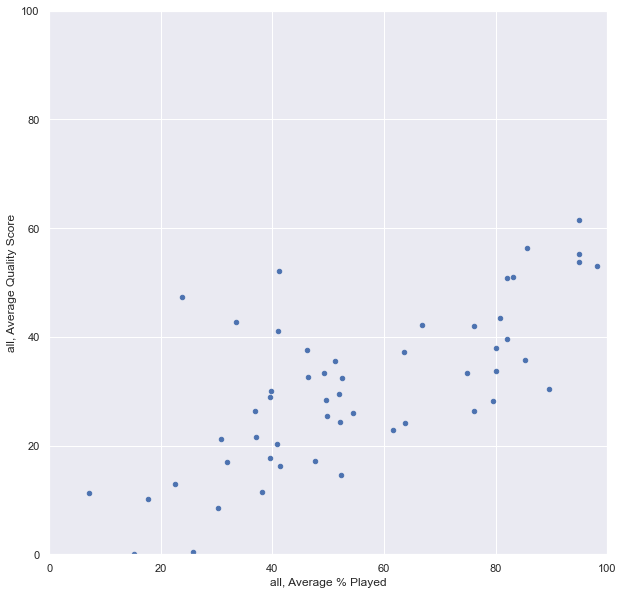

In [37]:
v2.plot.scatter(colname_played, colname_quality, xlim=(0,100), ylim=(0,100), figsize=(10,10))

In [38]:
v2.loc[v2[colname_quality] < 10]

,"-, clemscore","all, Average % Played","all, Average Quality Score","imagegame, % Played","imagegame, Quality Score","imagegame, Quality Score (std)","privateshared, % Played","privateshared, Quality Score","privateshared, Quality Score (std)","referencegame, % Played","referencegame, Quality Score","referencegame, Quality Score (std)","taboo, % Played","taboo, Quality Score","taboo, Quality Score (std)","wordle, % Played","wordle, Quality Score","wordle, Quality Score (std)","wordle_withclue, % Played","wordle_withclue, Quality Score","wordle_withclue, Quality Score (std)","wordle_withcritic, % Played","wordle_withcritic, Quality Score","wordle_withcritic, Quality Score (std)",ow/gt
models,,,,,,,,,,,,,,,,,,,,,,,,,
qwen1.5-0.5b-chat,0.12,25.72,0.48,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,86.67,1.92,13.87,46.67,0.0,0.0,40.0,0.0,0.0,6.67,0.0,0.0,ow
qwen1.5-1.8b-chat,0.00,15.24,0.00,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,93.33,0.00,0.00,0.00,NaN,NaN,10.0,0.0,0.0,3.33,0.0,NaN,ow
qwen1.5-7b-chat,2.58,30.24,8.53,0.0,NaN,NaN,0.0,NaN,NaN,100.0,20.56,40.52,98.33,13.56,33.26,0.00,NaN,NaN,10.0,0.0,0.0,3.33,0.0,NaN,ow


In [39]:
colname_played

'all, Average % Played'